In [1]:
import numpy as np
from numpy.linalg import norm
import scipy as sp
import ipywidgets as widgets
rng = np.random.default_rng(12345)
import matplotlib.pyplot as plt
from numba import jit

In [23]:
from numpy.linalg import norm
from scipy.optimize import minimize


class Pedestrian:
    """Constructs a Pedestrian. Add target for preferred direction.
    Also fix direction change billiard style
    Parameters
    ----------
    steps : int, optional
            Number of steps the Pedestrian will perform.
    speed : float, optional
            determines the size of each step of the Pedestrian
    
    Returns
    -------
    out :  object"""
    
    def __init__(self, steps=20, speed_mu=.6, target="Random",
                 position="Random", personal_space=10, obstacles=[[np.zeros(2),np.zeros(2)]]):
        self.speed = np.abs(rng.normal(speed_mu,0.15))
        if type(target) != np.ndarray:
            self.target = np.array([rng.uniform(0,100),rng.uniform(0,100)])
        else:
            self.target = target
        if type(position) != np.ndarray:
            self.position = np.array([rng.uniform(0,100),rng.uniform(0,100)])
        else:
            self.position = position
        self.direction = ((self.target - self.position)/norm(self.target - self.position))            
        self.direction_outlook = self.direction
        self.personal_space = personal_space
        self.history = np.zeros(2*(steps+1)).reshape(2,steps+1)
        self.current_step = 0
        self.obstacles = obstacles
    
               
    
    def expected(self):
        return self.position + self.speed * self.direction
    
    
    def assess_players(self,other_pedestrians):
        assert type(other_pedestrians) == list, "Pass a list of pedestrians."
        self.assess_positions = np.zeros(2*len(other_pedestrians)).reshape(2,len(other_pedestrians))
        for i, ped in enumerate(other_pedestrians):
            self.assess_positions[:,i] = ped.expected() 
    
    def assess_obstacles(self,exp_pos):
        #assert type(obstacles) == list, "Pass a list of obstacles."
        obstacles = self.obstacles
        dist_to_obstacles = 10e7*np.ones(len(obstacles))
        #exp_pos = self.position + self.speed * direction
        for i , obstacle in enumerate(obstacles):
            x = obstacle[0] - exp_pos
            y = obstacle[1] - exp_pos
            z = self.target - exp_pos
            cos_xy = np.round(np.dot(x,y)/(norm(x)*norm(y)),15)
            cos_xz = np.round(np.dot(x,z)/(norm(x)*norm(z)),15)
            cos_yz = np.round(np.dot(y,z)/(norm(y)*norm(z)),15)  
            angle_xy = np.arccos(cos_xy)
            angle_xz = np.arccos(cos_xz)
            angle_yz = np.arccos(cos_yz)
            if (angle_xy >= angle_xz) & (angle_xy >= angle_yz): # next direction towards obstacle
                cos_ = np.dot(obstacle[1]-obstacle[0],exp_pos-obstacle[0])/(norm(obstacle[1]-obstacle[0])*norm(exp_pos-obstacle[0]))
                dist = (norm(exp_pos-obstacle[0])* np.sqrt(1-cos_**2))
                if dist < 20:
                    dist_to_obstacles[i] = dist
        return 1/dist_to_obstacles
            
                            
                
    def walk(self):
        preferred = ((self.target - self.position) / norm(self.target - self.position)) 
        def f(direction):
            exp_pos = self.position + self.speed * direction
            exp_pos_obs = self.position + 4* self.speed * direction #This might be too long
            dissatisfaction = norm(self.assess_positions - exp_pos.reshape(2,1), axis=0)
            others_sensitivity, obstacles_sensitivity = 10e1, 10e2
            dissatisfaction = others_sensitivity/(.01+dissatisfaction)
            dissatisfaction_obs = obstacles_sensitivity*self.assess_obstacles(exp_pos_obs)
            inconvenience_f = norm(preferred-direction)**2
            return inconvenience_f + np.sum(dissatisfaction**2) + np.sum(dissatisfaction_obs)
        self.direction_outlook = minimize(f,self.direction).x
        self.position += self.speed * self.direction_outlook
        self.current_step += 1
        self.history[:,self.current_step] = self.position
        self.direction = self.direction_outlook

In [51]:
steps = int(1000)
n_agents = 5
pedestrians = []
bar_end1 = [np.array([80,25]), np.array([50,75])]
bar_end2 = [np.array([5,60]), np.array([45,60])]
obstacles = [bar_end1, bar_end2]
targets = rng.uniform(0,30,2*n_agents).reshape(2,n_agents)
positions = rng.uniform(40,100,2*n_agents).reshape(2,n_agents)
for agent in range(n_agents):
    pedestrians.append(Pedestrian(steps=steps,position=positions[:,agent],
                                  target=targets[:,agent],obstacles=obstacles))

for step in range(steps):
    for ped in pedestrians:
        ped.assess_players(list(filter(lambda x: x != ped, pedestrians)))
    for ped in pedestrians:
        ped.walk()

In [52]:
drag = 30
targets = [ped.target for ped in pedestrians]
size = 100
obstacles_plot = []
for obstacle in obstacles:
    obs_dir = obstacle[1]-obstacle[0]
    L = np.linspace(0,norm(obs_dir),size)
    barrier = np.ones(2*size).reshape(2,size)
    barrier[:,0] = obstacle[0]
    for i, l in enumerate(L):
            barrier[0,i] += obstacle[0][0] + l*(np.dot(obs_dir,np.array([1,0]))/norm(obs_dir))
            barrier[1,i] += obstacle[0][1] + l*np.sqrt(1-(np.dot(obs_dir,np.array([1,0]))/norm(obs_dir))**2)
    obstacles_plot.append(barrier)

    

@widgets.interact(n=(2,steps,5))
def plot(n=1):
    plt.figure(figsize=(5,5), dpi=80)
    plt.title(f"Time: {int(np.floor(n/60))}.{n%60}min")
    plt.xlim(-20,100)
    plt.ylim(-20,100)
    for obstacle_ in obstacles_plot:
        plt.scatter(obstacle_[0],obstacle_[1], s=10, label=f"Barrier")
        plt.gca().set_prop_cycle(None)
    for ped in pedestrians:
        plt.scatter(ped.target[0],ped.target[1], s=20, label=f"{ped}")
    plt.gca().set_prop_cycle(None)
    for ped in pedestrians:
        plt.scatter(ped.history[0,max(1,n-drag):n],ped.history[1,max(1,n-drag):n], s=3, label=f"{ped}")

[-30  50]
0.8705409696704832
[40  0]
0.5403023058681398
[51. 76.]


interactive(children=(IntSlider(value=2, description='n', max=1000, min=2, step=5), Output()), _dom_classes=('…

0.47295729759556404 0
0.7626855393623225 1
0.41942600321319023 2
0.776779634104509 3
0.44540012190198486 4


interactive(children=(IntSlider(value=2, description='n', max=1000, min=2, step=5), Output()), _dom_classes=('…

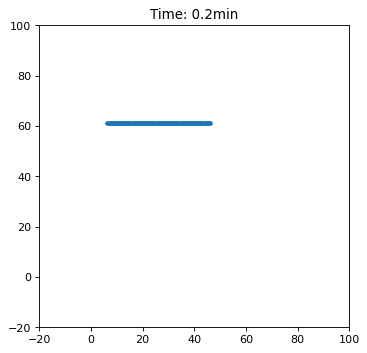

In [53]:
for i,ped in enumerate(pedestrians):
    if ped.speed > 0:
        print(ped.speed, i)

ped_n = 8
@widgets.interact(n=(2,steps,5))
def plot(n=1):
    plt.figure(figsize=(5,5), dpi=80)
    plt.title(f"Time: {int(np.floor(n/60))}.{n%60}min")
    plt.xlim(-20,100)
    plt.ylim(-20,100)
    plt.scatter(barrier[0],barrier[1], s=10, label=f"Barrier")
    plt.gca().set_prop_cycle(None)
    plt.scatter(pedestrians[ped_n].target[0],pedestrians[ped_n].target[1], s=20, label=f"{ped}")
    plt.gca().set_prop_cycle(None)
    plt.scatter(pedestrians[ped_n].history[0,max(1,n-drag):n],pedestrians[ped_n].history[1,max(1,n-drag):n], s=3, label=f"{ped}")

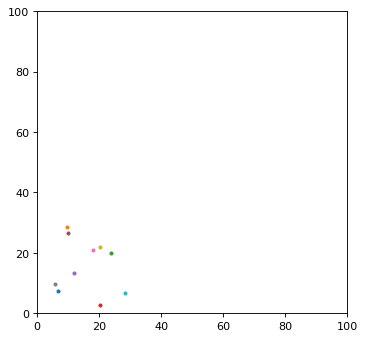

In [6]:
targets = [ped.target for ped in pedestrians]

plt.figure(figsize=(5,5), dpi=80)
plt.xlim(0,100)
plt.ylim(0,100)
for ped in pedestrians:
    plt.scatter(ped.target[0],ped.target[1], s=7, label=f"{ped}")

[0.33495182] 0.6650481805579304


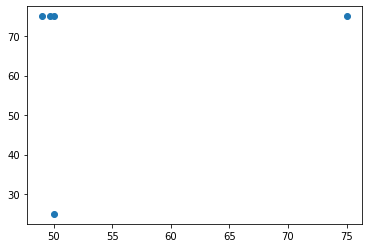

In [7]:
#Geometry   """Introduce statistics collector, geometry time step."""
target = np.array([75,75])
position = np.array([49,75])
bar_ends = [np.array([50,25]), np.array([50,75])]

ped = Pedestrian(position=position,target=target,obstacles=[bar_ends])
direction = np.array([1,0])

exp_pos = ped.position+ped.speed * ped.direction

print(1/ped.assess_obstacles(exp_pos), ped.speed)
plot_me = np.concatenate([ped.target.reshape(2,1),ped.position.reshape(2,1), 
                          exp_pos.reshape(2,1), 
                         bar_ends[0].reshape(2,1) , bar_ends[1].reshape(2,1)], axis=1)
plt.scatter(plot_me[0,:],plot_me[1:])

In [8]:
@widgets.interact(n=(1,steps,10))
def plot(n=1):
    plt.figure(figsize=(5,5), dpi=80)
    plt.xlim(0,100)
    plt.ylim(0,100)
    for ped in pedestrians:
        plt.scatter(ped.history[0,n],ped.history[1,n], s=3, label=f"{ped}")

interactive(children=(IntSlider(value=1, description='n', max=333, min=1, step=10), Output()), _dom_classes=('…

In [9]:
np.arccos??

Call signature:  np.arccos(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'arccos'>
File:            ~/miniconda3/envs/tf/lib/python3.8/site-packages/numpy/__init__.py
Docstring:      
arccos(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Trigonometric inverse cosine, element-wise.

The inverse of `cos` so that, if ``y = cos(x)``, then ``x = arccos(y)``.

Parameters
----------
x : array_like
    `x`-coordinate on the unit circle.
    For real arguments, the domain is [-1, 1].
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or None,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyword argument) must have length equal to the number of outputs.
where : array_like, optional
    This condition is broadcast over the input. At locations where t

In [10]:
n=908
norm(ped1.history[:,n]-ped2.history[:,n]),ped2.history[:,n], ped1.history[:,n]

NameError: name 'ped1' is not defined

In [ ]:
ped1.history.shape

In [ ]:
#plt.scatter(ped.history[0,:],ped.history[1,:])

ped.direction
#ped.barrier()
print(ped.walk())

In [ ]:
preferred = np.array([1,0])
def f(direction):
    return norm(preferred-direction)**2
x0 = np.array([-1,0])
minimize(f, x0).x


In [ ]:
# Use networkx defining station as a conencted graph and 1/0 for pepole in spot,
# probably best approach

In [ ]:
class Station:
    """Not used yet."""
    def __init__(self, size=100):
        self.station = np.array(size*size).reshape(size,size)

    
    def barrier(self):
        return self.barrier_e, self.barrier_w,  self.barrier_s, self.barrier_n
        

In [ ]:
from numpy.linalg import norm

class Pedestrian:
    """Constructs a Pedestrian. Add target for preferred direction.
    Also fix direction change billiard style
    Parameters
    ----------
    steps : int, optional
            Number of steps the Pedestrian will perform.
    speed : float, optional
            determines the size of each step of the Pedestrian
    
    Returns
    -------
    out :  object"""
    
    def __init__(self, steps=20, speed=1, target="No target", position="Random start",
                 personal_space=10):
        self.rush = np.abs(rng.standard_normal()) # Not used
        self.speed = speed
        if type(position) != np.ndarray:
            self.position = 30 + 50*rng.standard_normal(2)
        else:
            self.position = position
        if type(target) != np.ndarray:
            self.direction = np.array([np.cos(rng.standard_normal()), 
                                   np.sin(rng.standard_normal())])
        else:
            self.target = target
            self.direction = ((self.target - self.position)/
                               norm(self.target - self.position))            
        self.direction_outlook = self.direction
        self.personal_space = personal_space
        self.history = np.zeros(2*(steps+1)).reshape(2,steps+1)
        self.current_step = 0
        
    
        
    def _interaction(self):
        self.speed = self.speed
        self.direction_outlook = np.array([np.cos(rng.standard_normal()), 
                                           np.sin(rng.standard_normal())])
        
    
    def assess_barrier(self,barrier_e,barrier_w,barrier_s,barrier_n):
        if self.position[0] < barrier_e:
            self._interaction()
            self.direction_outlook[0] = np.abs(self.direction_outlook[0])
        if self.position[0] > barrier_w:
            self._interaction()
            self.direction_outlook[0] = -np.abs(self.direction_outlook[0])       
        if self.position[1] < barrier_s:
            self._interaction()
            self.direction_outlook[1] = np.abs(self.direction_outlook[1])
        if self.position[1] > barrier_n:
            self._interaction()
            self.direction_outlook[1] = -np.abs(self.direction_outlook[1])
    
    def expected(self):
        return self.position + self.speed * self.direction
    
    def assess_players(self,other_pedestrians):
        assert type(other_pedestrians) == list, "Pass a list of pedestrians."
        assess_positions = []
        for ped in other_pedestrians:
            assess_positions.append(ped.expected())
        
    
            
            
            
            if norm(self.position - ped.position) < self.personal_space:
                toss_coin = rng.choice([0,1])
                if toss_coin != 0: # 50% change of interaction
                    self.direction_outlook[0] = ped.direction[0]
                    self.direction_outlook[1] = ped.direction[1]
                    
                    '''# Copy direction of neighbours
                    self.direction_outlook[0] = ped.direction[0]
                    self.direction_outlook[1] = ped.direction[1]
                    self.direction_outlook[0] = - ped.direction[1]
                    self.direction_outlook[1] = ped.direction[0]'''
                
    def walk(self):
        self.position += self.speed * self.direction_outlook
        self.current_step += 1
        self.history[:,self.current_step] = self.position
        self.direction = self.direction_outlook

In [ ]:
x = np.arange(2*10).reshape(2,10)
y = np.array([1,1])
x, x-y.reshape(2,1)

this = x-y.reshape(2,1)
this, 1/(1+norm(this, axis = 0))